In [3]:
import sys
print(sys.version)
print(sys.platform)

3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
win32


In [4]:
import sys, sklearn, numpy, joblib, imblearn

print("Python:", sys.version)
print("scikit-learn:", sklearn.__version__)
print("numpy:", numpy.__version__)
print("joblib:", joblib.__version__)
print("imbalanced-learn:", imblearn.__version__)

Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
scikit-learn: 1.3.2
numpy: 1.24.4
joblib: 1.3.2
imbalanced-learn: 0.11.0


In [5]:
!python -m pip install seaborn optuna

In [6]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import optuna
from sklearn.decomposition import PCA

In [7]:
# Load the dataset
file_path = "C:\\Users\\B760M-ITX D4 WIFI\\Documents\\GitHub\\ros-security\\dataset\\existing\\NavBot25.csv"
data = pd.read_csv(file_path)

In [8]:
# Display dataset info
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192213 entries, 0 to 192212
Data columns (total 84 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow ID            192213 non-null  object 
 1   Src IP             192213 non-null  object 
 2   Src Port           192213 non-null  int64  
 3   Dst IP             192213 non-null  object 
 4   Dst Port           192213 non-null  int64  
 5   Protocol           192213 non-null  int64  
 6   Timestamp          192213 non-null  object 
 7   Flow Duration      192213 non-null  int64  
 8   Tot Fwd Pkts       192213 non-null  int64  
 9   Tot Bwd Pkts       192213 non-null  int64  
 10  TotLen Fwd Pkts    192213 non-null  float64
 11  TotLen Bwd Pkts    192213 non-null  float64
 12  Fwd Pkt Len Max    192213 non-null  float64
 13  Fwd Pkt Len Min    192213 non-null  float64
 14  Fwd Pkt Len Mean   192213 non-null  float64
 15  Fwd Pkt Len Std    192213 non-null  float64
 16  Bw

In [9]:
print(data['Label'].value_counts())

Label
Normal                  63017
Port Scanning Attack    29895
DoS Attack              29888
Reverse Shell           29525
UnauthSub Attack        25914
SSH Bruteforce           6134
Pubflood                 4715
Subflood                 3125
Name: count, dtype: int64


In [10]:
# Define attack type mapping
attack_mapping = {
    "Normal": 0,
    "DoS Attack": 1,
    "UnauthSub Attack": 2,
    "SSH Bruteforce": 3,
    "Pubflood": 4,
    "Subflood": 5,
    "Reverse Shell": 6,
    "Port Scanning Attack": 7
}

# Convert attack type names to numeric labels
data["Label"] = data["Label"].map(attack_mapping)

# Drop rows with unmatched labels (if any)
data = data.dropna(subset=["Label"])

# Ensure labels are integers
data["Label"] = data["Label"].astype(int)

In [11]:
# Drop unnecessary columns
columns_to_drop = ['Flow ID', 'Src IP', 'Dst IP', 'Protocol', 'Timestamp']
data = data.drop(columns=columns_to_drop, errors='ignore')

# Check if any column is non-numeric
non_numeric_columns = data.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

# Handle missing values for numeric columns only
numeric_columns = data.select_dtypes(include=['number']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Check the dataset again
print(data.info())

Non-numeric columns: Index([], dtype='object')
 Index([], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192213 entries, 0 to 192212
Data columns (total 79 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Src Port           192213 non-null  int64  
 1   Dst Port           192213 non-null  int64  
 2   Flow Duration      192213 non-null  int64  
 3   Tot Fwd Pkts       192213 non-null  int64  
 4   Tot Bwd Pkts       192213 non-null  int64  
 5   TotLen Fwd Pkts    192213 non-null  float64
 6   TotLen Bwd Pkts    192213 non-null  float64
 7   Fwd Pkt Len Max    192213 non-null  float64
 8   Fwd Pkt Len Min    192213 non-null  float64
 9   Fwd Pkt Len Mean   192213 non-null  float64
 10  Fwd Pkt Len Std    192213 non-null  float64
 11  Bwd Pkt Len Max    192213 non-null  float64
 12  Bwd Pkt Len Min    192213 non-null  float64
 13  Bwd Pkt Len Mean   192213 non-null  float64
 14  Bwd Pkt Len Std    192213 

In [12]:
# Split into features (X) and target (y)
X = data.drop('Label', axis=1)  # Features
y = data['Label']  # Target

In [13]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (153770, 78)
Testing set size: (38443, 78)
 (153770, 78)
Testing set size: (38443, 78)


In [14]:
# Check for NaN values
print("NaN values in X_train:", np.isnan(X_train).sum().sum())
print("NaN values in X_test:", np.isnan(X_test).sum().sum())

# Check for infinity values
print("Infinity values in X_train:", np.isinf(X_train).sum().sum())
print("Infinity values in X_test:", np.isinf(X_test).sum().sum())

NaN values in X_train: 0
NaN values in X_test: 0
Infinity values in X_train: 0
Infinity values in X_test: 0


In [15]:
# Replace NaN and infinity with the mean of the column
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill NaN with column mean
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [16]:
# Print original class distribution
print("Original class distribution:")
print(y_train.value_counts())

Original class distribution:
Label
0    50395
1    23975
7    23888
6    23595
2    20722
3     4885
4     3800
5     2510
Name: count, dtype: int64


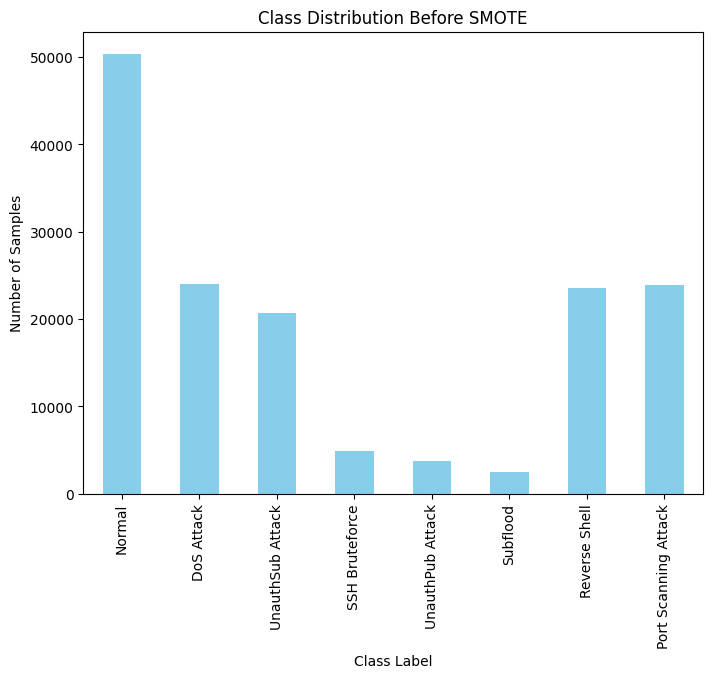

In [17]:
# Plot class distribution before SMOTE
plt.figure(figsize=(8, 6))
y_train.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before SMOTE")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['Normal', 'DoS Attack', 'UnauthSub Attack', 'SSH Bruteforce', 'UnauthPub Attack', 'Subflood', 'Reverse Shell', 'Port Scanning Attack'])
plt.show()

In [18]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_train_balanced.value_counts())

c:\Users\B760M-ITX D4 WIFI\.conda\envs\py310\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Class distribution after SMOTE:
Label
0    50395
7    50395
2    50395
4    50395
1    50395
6    50395
3    50395
5    50395
Name: count, dtype: int64


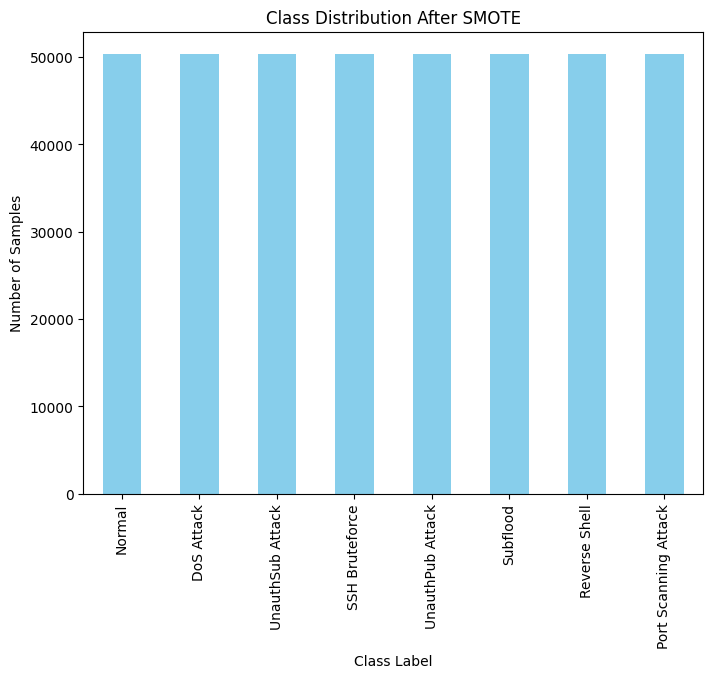

In [19]:
# Plot class distribution after SMOTE
plt.figure(figsize=(8, 6))
y_train_balanced.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After SMOTE")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['Normal', 'DoS Attack', 'UnauthSub Attack', 'SSH Bruteforce', 'UnauthPub Attack', 'Subflood', 'Reverse Shell', 'Port Scanning Attack'])
plt.show()

In [20]:
def scale_data(X_train, X_test, scale_data=True):
    """
    Scales the data if scale_data is True.
    """
    if scale_data:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    return X_train_scaled, X_test_scaled, scaler

In [21]:
def compute_mutual_info(X_train_scaled, y_train):
    """
    Computes mutual information (MI) scores for the features in X_train.
    """
    mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)

    # Create MI DataFrame with rank
    mi_df = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False).reset_index(drop=True)
    mi_df['Rank'] = mi_df.index + 1

    return mi_df

[INFO] Top 20 Features by Mutual Information Scores:
              Feature  MI_Score  Rank
0            Dst Port  1.849471     1
1            Src Port  1.709450     2
2      Bwd Header Len  1.627406     3
3         Bwd IAT Tot  1.560519     4
4          Bwd Pkts/s  1.559299     5
5        Bwd IAT Mean  1.527130     6
6        Pkt Len Mean  1.504860     7
7         Flow Pkts/s  1.504085     8
8        Pkt Size Avg  1.500917     9
9       Flow Duration  1.495409    10
10        Bwd IAT Max  1.489342    11
11        Pkt Len Std  1.486351    12
12        Pkt Len Var  1.486162    13
13      Flow IAT Mean  1.469798    14
14    TotLen Bwd Pkts  1.461737    15
15   Subflow Bwd Byts  1.452711    16
16   Bwd Seg Size Avg  1.439546    17
17   Bwd Pkt Len Mean  1.438520    18
18       Flow IAT Max  1.400159    19
19  Init Bwd Win Byts  1.349338    20


C:\Users\B760M-ITX D4 WIFI\AppData\Local\Temp\ipykernel_45792\1687345405.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI_Score', y='Feature', data=top_k, palette='viridis')


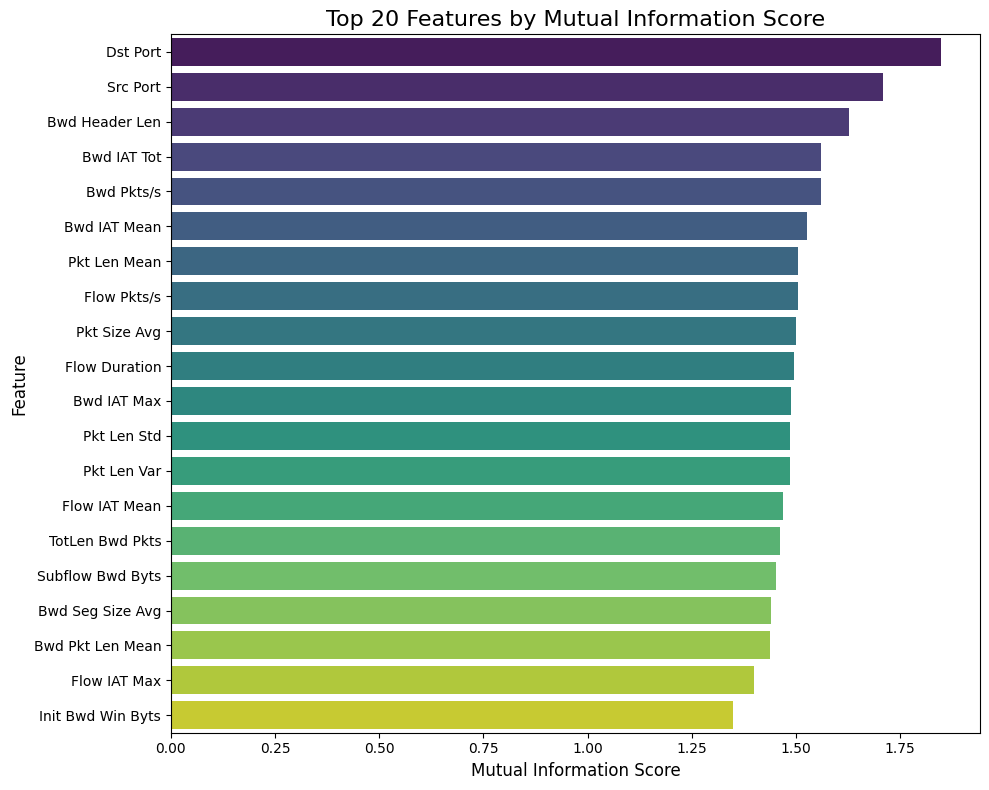

[INFO] Selected 63 Features:
['Dst Port', 'Src Port', 'Bwd Header Len', 'Bwd IAT Tot', 'Bwd Pkts/s', 'Bwd IAT Mean', 'Pkt Len Mean', 'Flow Pkts/s', 'Pkt Size Avg', 'Flow Duration', 'Bwd IAT Max', 'Pkt Len Std', 'Pkt Len Var', 'Flow IAT Mean', 'TotLen Bwd Pkts', 'Subflow Bwd Byts', 'Bwd Seg Size Avg', 'Bwd Pkt Len Mean', 'Flow IAT Max', 'Init Bwd Win Byts', 'Pkt Len Max', 'Flow Byts/s', 'Fwd Pkts/s', 'Fwd Header Len', 'Flow IAT Std', 'Bwd IAT Min', 'Subflow Bwd Pkts', 'Tot Bwd Pkts', 'Bwd Pkt Len Max', 'Bwd IAT Std', 'Flow IAT Min', 'Tot Fwd Pkts', 'Subflow Fwd Pkts', 'Bwd Pkt Len Std', 'Bwd Pkt Len Min', 'Fwd IAT Mean', 'Fwd IAT Tot', 'Down/Up Ratio', 'Idle Min', 'Idle Mean', 'Idle Max', 'Fwd IAT Min', 'Active Max', 'Fwd IAT Max', 'Active Mean', 'Active Min', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Fwd IAT Std', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Seg Size Avg', 'Subflow Fwd Byts', 'TotLen Fwd Pkts', 'PSH Flag Cnt', 'Bwd PSH Flags', 'Idle Std', 'Active Std', 'Fwd Act Data Pkts', 'Fwd 

In [22]:
def plot_top_features(mi_df, top_n=20):
    """
    Plots the top_n features based on their Mutual Information (MI) scores.
    """
    top_k = mi_df.head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='MI_Score', y='Feature', data=top_k, palette='viridis')
    plt.title(f'Top {top_n} Features by Mutual Information Score', fontsize=16)
    plt.xlabel('Mutual Information Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

# First, scale the data and get the scaler
X_train_scaled, X_test_scaled, scaler = scale_data(X_train_balanced, X_test, scale_data=True)

# Then, compute mutual information
mi_df = compute_mutual_info(X_train_scaled, y_train_balanced)

# Print Top 20 Features based on MI Scores
print("[INFO] Top 20 Features by Mutual Information Scores:")
print(mi_df.head(20))

# Plot the top 20 features
plot_top_features(mi_df, top_n=20)

# Select features based on the mutual information threshold
selected_features = mi_df[mi_df['MI_Score'] >= 0.01]['Feature'].tolist()

# Now select the features from the original data
X_train_selected = X_train_balanced[selected_features]
X_test_selected = X_test[selected_features]

# Ensure X_train_selected has the same columns as X_test_selected
X_train_selected = X_train_balanced[X_test_selected.columns]  # Align training data to test features

# Apply scaling to both the train and test data using the same scaler (that was used previously)
X_train_scaled = scaler.fit_transform(X_train_selected)  # Fit and transform the train data
X_test_scaled = scaler.transform(X_test_selected)  # Transform the test data

# Print total number of selected features and their names
print(f"[INFO] Selected {len(selected_features)} Features:")
print(selected_features)

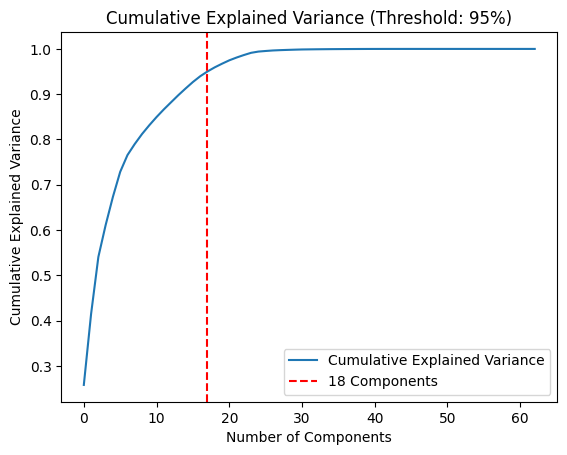

In [23]:
# Perform PCA
pca = PCA()
pca.fit(X_train_scaled)

# Get explained variance ratio and cumulative variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot the cumulative explained variance ratio
plt.plot(cumulative_variance_ratio, label='Cumulative Explained Variance')

# Set a threshold (e.g. 95% variance explained)
threshold = 0.95
component_count = next((i for i, val in enumerate(cumulative_variance_ratio) if val >= threshold), len(cumulative_variance_ratio)-1)

# Plot the vertical line
plt.axvline(x=component_count, color='red', linestyle='--', label=f'{component_count+1} Components')

# Label the plot
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend(loc='best')
plt.title(f'Cumulative Explained Variance (Threshold: {threshold*100:.0f}%)')

# Show plot
plt.show()

In [24]:
# Metrics calculation function
def calculate_metrics(y_true, y_pred, conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1-score": f1
    }

    return metrics

def display_metrics(metrics):
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.ljust(12)}: {metric_value * 100:.2f}%")

In [25]:
# Train a base Decision Tree model before hyperparameter tuning
print("Training base Decision Tree model...")
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train_scaled, y_train_balanced)
dt_base_preds = dt_base.predict(X_test_scaled)

Training base Decision Tree model...


In [26]:
# Generate and display metrics and confusion matrix for base model
print("\nBase Decision Tree Performance:")
print(classification_report(y_test, dt_base_preds, digits=4))
print(f"Accuracy: {accuracy_score(y_test, dt_base_preds):.4f}")
    
conf_matrix_base = confusion_matrix(y_test, dt_base_preds)


Base Decision Tree Performance:
              precision    recall  f1-score   support

           0     0.9999    0.9996    0.9998     12622
           1     1.0000    1.0000    1.0000      5913
           2     0.9998    0.9996    0.9997      5192
           3     0.9984    1.0000    0.9992      1249
           4     1.0000    1.0000    1.0000       915
           5     0.9968    0.9984    0.9976       615
           6     0.9998    0.9998    0.9998      5930
           7     0.9997    1.0000    0.9998      6007

    accuracy                         0.9998     38443
   macro avg     0.9993    0.9997    0.9995     38443
weighted avg     0.9998    0.9998    0.9998     38443

Accuracy: 0.9998


Text(0.5, 1.0, 'Confusion Matrix - Count (Base DT)')

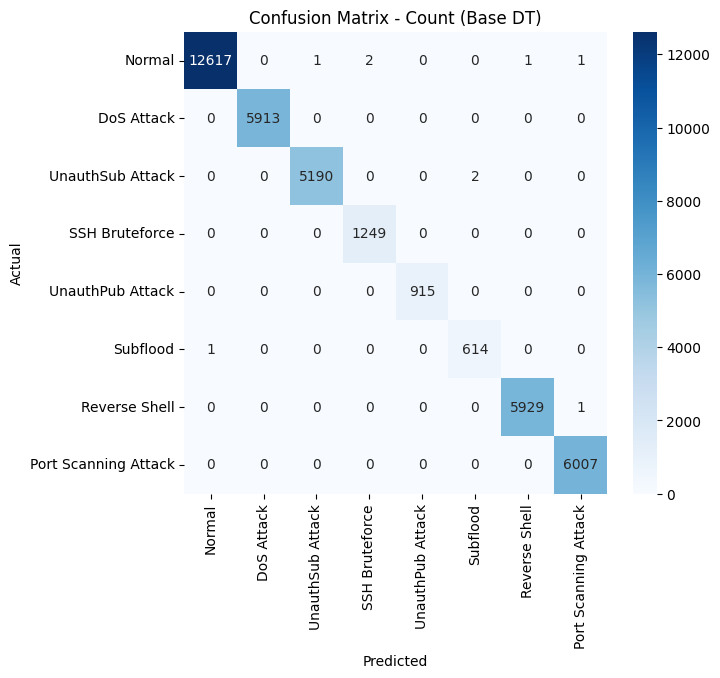

In [27]:
# Display confusion matrix as count
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'DoS Attack', 'UnauthSub Attack', 'SSH Bruteforce', 'UnauthPub Attack', 'Subflood', 'Reverse Shell', 'Port Scanning Attack'], 
            yticklabels=['Normal', 'DoS Attack', 'UnauthSub Attack', 'SSH Bruteforce', 'UnauthPub Attack', 'Subflood', 'Reverse Shell', 'Port Scanning Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Count (Base DT)')

In [28]:
# Define the Optuna objective function
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )

    try:
        model.fit(X_train_scaled, y_train_balanced)
        y_pred = model.predict(X_test_scaled)
        score = f1_score(y_test, y_pred, average='macro')  # <-- FIXED HERE
    except Exception as e:
        print(f"Exception in Optuna trial: {e}")
        return 0.0

    return score

# Run Optuna optimization
print("\nStarting Optuna hyperparameter optimization with 15 trials...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# Best hyperparameters
best_params = study.best_params
print(f"\nBest hyperparameters found: {best_params}")

# Train final model
print("\nTraining Decision Tree with optimized hyperparameters...")
dt_tuned = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    random_state=42
)
dt_tuned.fit(X_train_scaled, y_train_balanced)
dt_tuned_preds = dt_tuned.predict(X_test_scaled)

[I 2025-09-24 10:06:11,865] A new study created in memory with name: no-name-64859e77-ca89-4326-9cf3-1aae93bd6b04



Starting Optuna hyperparameter optimization with 15 trials...


[I 2025-09-24 10:06:18,800] Trial 0 finished with value: 0.9994063729138409 and parameters: {'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9994063729138409.
[I 2025-09-24 10:06:26,118] Trial 1 finished with value: 0.9988930783228712 and parameters: {'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.9994063729138409.
[I 2025-09-24 10:06:26,118] Trial 1 finished with value: 0.9988930783228712 and parameters: {'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.9994063729138409.
[I 2025-09-24 10:06:33,318] Trial 2 finished with value: 0.9990817696461556 and parameters: {'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.9994063729138409.
[I 2025-09-24 10:06:33,318] Trial 2 finished with value: 0.9990817696461556 and parame


Best hyperparameters found: {'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy'}

Training Decision Tree with optimized hyperparameters...


In [29]:
# Train a new model with the best hyperparameters
print("\nTraining Decision Tree with optimized hyperparameters...")
dt_tuned = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    random_state=42
)
dt_tuned.fit(X_train_scaled, y_train_balanced)
dt_tuned_preds = dt_tuned.predict(X_test_scaled)


Training Decision Tree with optimized hyperparameters...


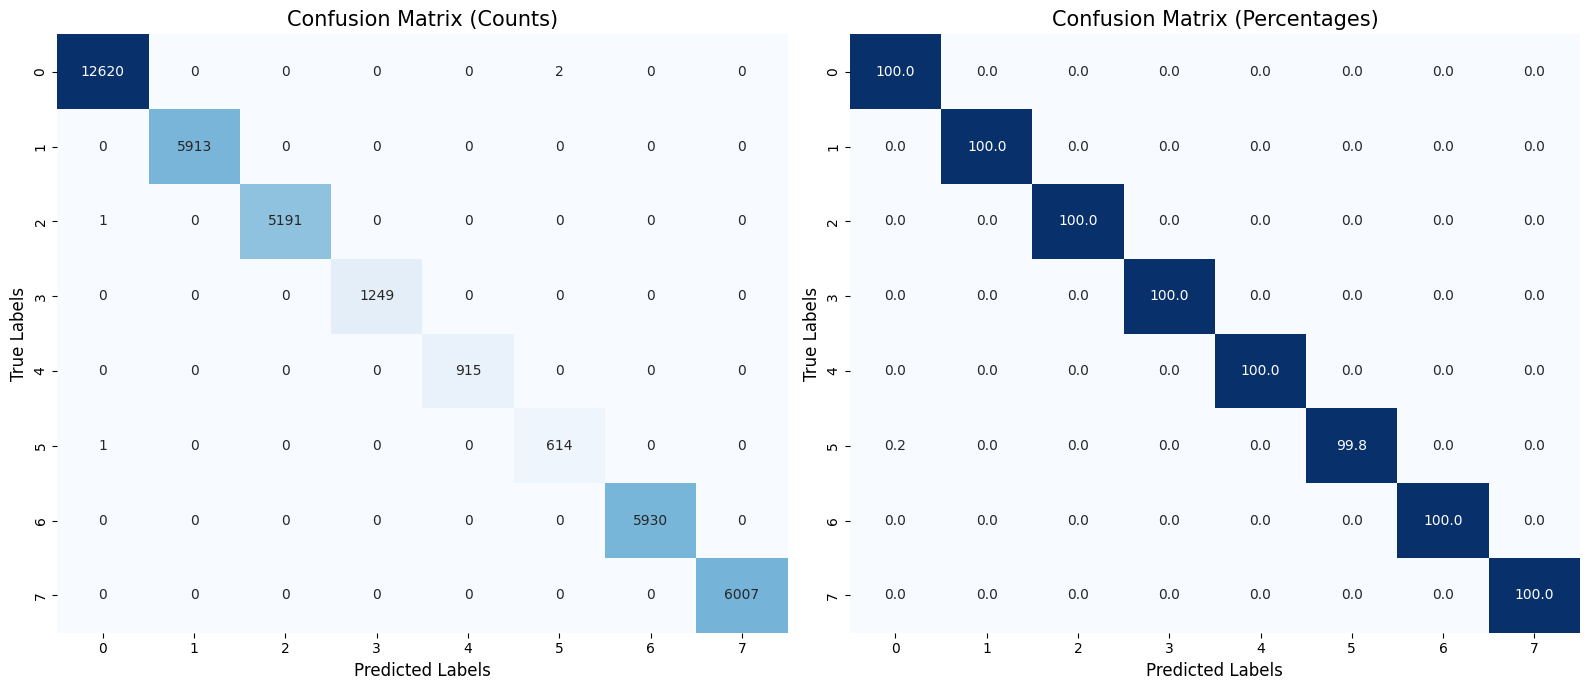


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12622
           1       1.00      1.00      1.00      5913
           2       1.00      1.00      1.00      5192
           3       1.00      1.00      1.00      1249
           4       1.00      1.00      1.00       915
           5       1.00      1.00      1.00       615
           6       1.00      1.00      1.00      5930
           7       1.00      1.00      1.00      6007

    accuracy                           1.00     38443
   macro avg       1.00      1.00      1.00     38443
weighted avg       1.00      1.00      1.00     38443


Accuracy: 0.9999


In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the confusion matrix
cm = confusion_matrix(y_test, dt_tuned_preds)

# Create a figure with two subplots
plt.figure(figsize=(16, 7))

# Plot 1: Confusion Matrix (Counts)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Counts)', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Plot 2: Confusion Matrix (Percentages)
plt.subplot(1, 2, 2)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Percentages)', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

plt.tight_layout()
plt.show()

# Print classification report for additional metrics
from sklearn.metrics import classification_report
print('\nClassification Report:')
print(classification_report(y_test, dt_tuned_preds))

# Print overall accuracy
from sklearn.metrics import accuracy_score
print(f'\nAccuracy: {accuracy_score(y_test, dt_tuned_preds):.4f}')


Performing 5-Fold Cross Validation...
Cross-validation scores for each fold: [0.99983877 0.99988838 0.99880941 0.99831332 0.99826372]
Mean accuracy: 0.9990227205079869
Standard deviation: 0.0007127614865535361
Cross-validation scores for each fold: [0.99983877 0.99988838 0.99880941 0.99831332 0.99826372]
Mean accuracy: 0.9990227205079869
Standard deviation: 0.0007127614865535361


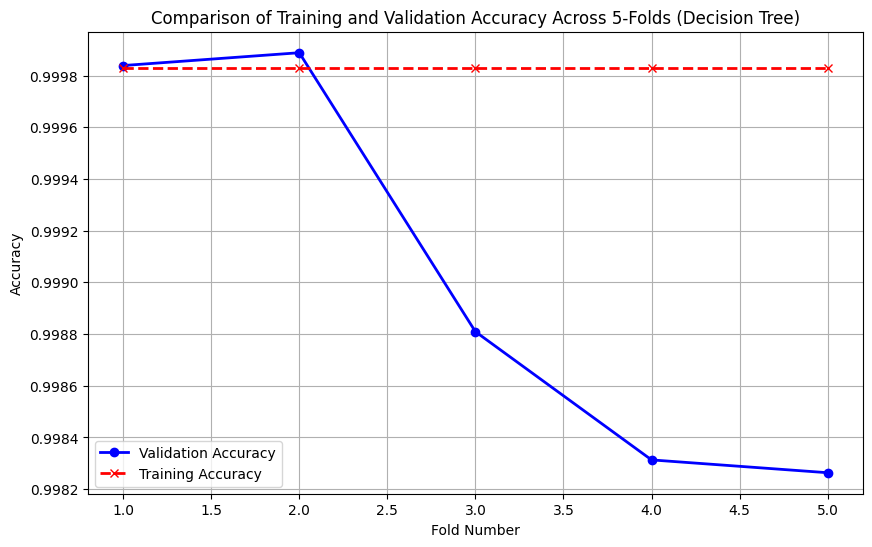

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Step 1: Perform 5-fold cross-validation
print("\nPerforming 5-Fold Cross Validation...")
cv_scores = cross_val_score(dt_tuned, X_train_scaled, y_train_balanced, cv=5)

# Step 2: Print cross-validation results
print(f"Cross-validation scores for each fold: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores)}")
print(f"Standard deviation: {np.std(cv_scores)}")

# Step 3: Visualize the comparison between the folds
plt.figure(figsize=(10, 6))

# Plot for cross-validation scores
plt.plot(range(1, 6), cv_scores, marker='o', label='Validation Accuracy', color='blue', linestyle='-', linewidth=2)

# Optional: If you want to compare training accuracy, you can also plot it (assuming you have training data available)
train_scores = [dt_tuned.fit(X_train_scaled, y_train_balanced).score(X_train_scaled, y_train_balanced) for _ in range(5)]  # Mock training accuracy for each fold

# Plot training accuracy for comparison (optional)
plt.plot(range(1, 6), train_scores, marker='x', label='Training Accuracy', color='red', linestyle='--', linewidth=2)

# Labels and title
plt.title('Comparison of Training and Validation Accuracy Across 5-Folds (Decision Tree)')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [32]:
from joblib import dump

# Save the trained Decision Tree model
dump(dt_base, "model.joblib")
print("Model saved as model.joblib")

Model saved as model.joblib


In [ ]:
dump(scaler, "scaler.joblib")
print("Scaler saved as scaler.joblib") 

Scaler saved as scaler.joblib


In [34]:
features = list(X.columns)   # or whatever your feature DataFrame is called
with open("features.txt", "w") as f:
    for feat in features:
        f.write(feat + "\n")

print("Features saved as features.txt")

Features saved as features.txt
